# Model Building and Hyperparameter tuning
### By: Ana María Ramos 
### Advisor: Arles Rodríguez
### Universidad Nacional de Colombia

In this notebook, we'll explore the process of building a Multilayer Perceptron (MLP), a type of Feed Forward Neural Network which generalizes a Perceptron to a model with at least one hidden layer, and then use it to predict risk ratings for life insurance applicants. To accomplish this, we'll utilize the TF Keras Sequential API for constructing the risk classifier, and leverage the TF KerasTuner API for efficient hyperparameter tuning of the model.

The dataset we'll work with was initially released for a Kaggle competition sponsored by the Prudential Financial company [[1]](#R-1). It encompasses more than a hundred variables describing various attributes of life insurance applicants. Our objective is to predict the "Response" variable for each applicant in the test set. "Response" represents an ordinal measure of risk categorized into 8 levels.


**By the end of this lab, you'll be able to:**

- Construct and train a Multilayer Perceptron Neural Network in Keras TensorFlow for a multiclass classification problem.
- Perform hyperparameter tuning of your Keras Neural Network models through disctinct automated techniques such as Grid Search, Random Search, and Hyperband.
- Utilize customized metrics for the hyperparameter tuning process.
- Familiarize yourself with the Quadratic Weighted Kappa metric tailored for ordinal classification tasks and integrate it into your projects.
- Apply your knowledge of neural network models to address a range of actuarial and financial tasks related to risk classification.

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Explore the Data](#2)
- [3 - Build model and tune hyperparamters](#3)
    - [3.1 - Build the Model and Define the Hyperparameters](#3-1)
        - [3.1.1 - Special case for mini-batch size tuning](#3-1-1)
        - [Exercise 1 - Defining Hyperparameters within the Model](#ex-1)
    - [3.2 - Search for the Best Hyperparameters](#3-2)
        - [Exercise 2 - Search for the Best Hyperparameters](#ex-2)
- [4 - Expanded Keras Tuner Features](#4)
    - [4.1 - Use Custom Metrics](#4-1)
    - [4.2 - Tailor the Search Space](#4-2)
    - [Exercise 3 - Prioritized Hyperparameter Tuning with Custom Metric](#ex-3)
- [5 - Fit and Evaluate Tuned Model](#5)
    - [Exercise 4 - Fit and Predict with Tuned Model](#ex-4)
    - [5.1 - See Tuned Model Perfomance](#ex-3)
- [6 - Bibliography](#6)

<a name='1'></a>
## 1 - Packages

Let's start by importing all the necessary libraries for building our neural network model, tuning the hyperparameters, and evaluating the model's performance.

In [1]:
import nbimporter
import LIA_Tutorial_Utils
import io
import sys
import math
import numpy as np # linear algebra
import pandas as pd # data visualization, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphs/plotting
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder
from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


<a name='2'></a>
## 2 - Load and Explore the Data

Execute the cells below in order to load and generate a summary of the data.

In [2]:
# Load the data
x_full, y_full, x_train, x_valid, x_test, y_train, y_valid, y_test= LIA_Tutorial_Utils.load_data()

In [3]:
# Review the main characteristics of the dataset features
print("Data Set Features Description\n------------------------------\n", x_full.dtypes)
x_full.describe()

Data Set Features Description
------------------------------
 Product_Info_4         float64
Product_Info_6         float64
Ins_Age                float64
BMI                    float64
Employment_Info_3      float64
Employment_Info_5      float64
InsuredInfo_4          float64
InsuredInfo_5          float64
InsuredInfo_6          float64
InsuredInfo_7          float64
Insurance_History_1    float64
Insurance_History_2    float64
Insurance_History_3    float64
Insurance_History_4    float64
Insurance_History_9    float64
Family_Hist_1          float64
Medical_History_3      float64
Medical_History_4      float64
Medical_History_6      float64
Medical_History_11     float64
Medical_History_13     float64
Medical_History_14     float64
Medical_History_16     float64
Medical_History_17     float64
Medical_History_20     float64
Medical_History_22     float64
Medical_History_23     float64
Medical_History_26     float64
Medical_History_27     float64
Medical_History_28     float64
Medical_

,Product_Info_4,Product_Info_6,Ins_Age,BMI,Employment_Info_3,Employment_Info_5,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,...,Medical_Keyword_40,Medical_Keyword_48,Product_Info_2_A6,Product_Info_2_A7,Product_Info_2_A8,Product_Info_2_D1,Product_Info_2_D2,Product_Info_2_D3,Product_Info_2_D4,Product_Info_2_E1
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,...,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,0.328952,0.836800,0.405567,0.436295,0.150452,0.142958,0.883666,0.013590,0.409188,0.019265,...,0.056954,0.054496,0.035331,0.023290,0.115104,0.110372,0.105859,0.241171,0.182078,0.044577
std,0.282562,0.369551,0.197190,0.129853,0.357517,0.350033,0.320627,0.115783,0.491688,0.137458,...,0.231757,0.226995,0.184617,0.150825,0.319150,0.313356,0.307659,0.427798,0.385912,0.206374
min,0.000000,0.000000,0.000000,-0.062516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076923,1.000000,0.238806,0.347102,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.230769,1.000000,0.402985,0.417050,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.487179,1.000000,0.567164,0.503654,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Display the features of the first 5 data points
x_full.head()

,Product_Info_4,Product_Info_6,Ins_Age,BMI,Employment_Info_3,Employment_Info_5,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,...,Product_Info_2_A8,Product_Info_2_D1,Product_Info_2_D2,Product_Info_2_D3,Product_Info_2_D4,Product_Info_2_E1,KMeansCluster_4,KMeansCluster_5,KMeansCluster_11,KMeansCluster_13
Id,,,,,,,,,,,,,,,,,,,,,
2,0.076923,0.0,0.641791,0.280685,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
5,0.076923,1.0,0.059701,0.226794,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
6,0.076923,1.0,0.029851,0.393070,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,False
7,0.487179,1.0,0.164179,0.311955,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,0.230769,1.0,0.417910,0.388039,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We have approximately 59,000 data points describing life insurance applicants' information related to age, employment status, medical conditions, and other factors. The dataset has already been preprocessed and normalized following the precedures in [10](#R-10), with the independent variables being now of type float. If you're interested in obtaining the raw data you can refer to [1](#R-1).  

Let's now take a look at the response variable of our dataset.

In [5]:
# Review the main characteristics of the dataset labels (risk ratings)
print("Data Set Labels Description: \n\n", y_full.dtypes)
y_full.describe()

Data Set Labels Description: 

 Response    int64
dtype: object


,Response
count,59381.000000
mean,5.636837
std,2.456833
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,8.000000


In [6]:
# Display first 5 values of applicants' risk ratings
y_full.head()

,Response
Id,
2,8
5,4
6,8
7,8
8,8


Text(0.5, 1.0, 'Response Distribution')

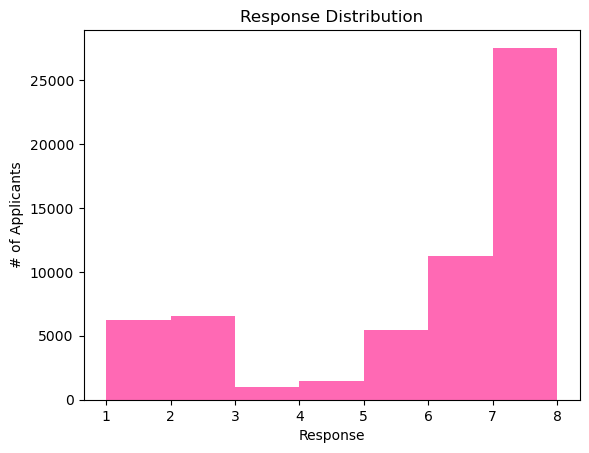

In [7]:
# Visualize the distribution of applicants' risk ratings in the full dataset.
plt.hist(y_full['Response'], bins=sorted(y_full['Response'].unique()), color = "hotpink")
plt.xlabel('Response')
plt.ylabel('# of Applicants')
plt.title('Response Distribution')

The histogram above shows the full dataset's distribution of applicants by their determined risk ratings (i.e. Response) showcasing ratings ranging from 1 to 8. We can see that our data suffers from class imbalance, with rating 8 being the most prevalent while ratings 3 and 4 are the least represented.

Now, an important consideration when using the Keras API is that it requires categorical variables to be encoded as integers ranging from 0 to k-1, where k represents the number of classes. In our case, since we have 8 ratings, we'll need to encode our response variable to range from 0 to 7 before proceeding with the model development.

In [8]:
# Label-encode each dataset for compatibility with keras TensorFlow API
le = LabelEncoder()
# Convert each set of class labels (1-8) into encoded labels (0-7).
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [9]:
keras.utils.set_random_seed(5)

<a name='3'></a>
## 3 - Build model and tune hyperparameters

In this section, we'll delve into the process of building a model and tuning hyperparameters using the Keras Tuner API. Subsequently, we'll construct a multilayer perceptron model for our risk classification task and proceed to tune its respective hyperparameters using random search. We'll adopt a straightforward approach by simultaneously tuning the number of layers, units per layer, activation function of the hidden layers, learning rate, and mini-batch size hyperparameters, optimizing with respect to the accuracy metric.

## 3.1 - Build the Model and Define the Hyperparameters

In this tutorial, we'll utilize the TensorFlow Keras Sequential API to construct our model. This API allows you to build layer by layer, making it particularly suitable for models with precisely one input tensor and one output tensor per layer. To optimize the hyperparameters using the Keras Tuner library, we'll define and build our Keras Sequential model within the `build` method of a subclass of the Keras Tuner `HyperModel` class. Below is a skeletal representation illustrating the code structure:

```python
class MyHyperModel(kt.HyperModel):
    def build(self, hp):        

        model = keras.Sequential()  # Initialize Keras model here                        
        model.add(...)              # Build the model 
        ...                         
        model.compile(...)          # Compile the model
        
        return model                # Return the compiled model                                       
```    

To define the hyperparameters, use the `hp` parameter of the build function, which is passed as a `HyperParameters` class instance during execution. The method of the HyperParameters class to use depends on the type of the hyperparameter to be tuned.
For example, to tune the number of units in some hidden layer, we use the `HyperParameters.Int()` method:


```python

class MyHyperModel(kt.HyperModel):
   def build(self, hp):
    
       model = keras.Sequential()      
           
       # Add hidden layer
       model.add(keras.layers.Dense(             
           # Make the number of units a hyperparameter that can take values 
           # in the range [12, 13, 14, ..., 88, 89, 90], inclusive. 
           units = hp.Int('units', min_value=12, max_value=90), 
           activation = 'relu'))                                         

       # Add output layer
       model.add(Dense(units=1, activation='sigmoid'))

    
       # Compile the model 
       model.compile(optimizer = 'adam',                       
                     loss = keras.losses.BinaryCrossentropy(), 
                     metrics = ['accuracy'])  
          
       return model  
     
```
We can also dynamically add hidden layers based on a hyperparameter:

```python

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        
        model = keras.Sequential()  
        
        # Define a hyperparameter for the number of hidden layers
        # Try with [6, 9, 12] as possible values for the hyperparameter
        hp_layers = hp.Int("n_layers", min_value=6, max_value=13, step=3) 
        
        # Add hidden layers dynamically based on the hyperparameter
        for i in range(hp_layers):
             model.add(keras.layers.Dense(units=20, activation='relu'))
        
        # Finish building and compiling model         
        model.add(Dense(units=1, activation='sigmoid'))
        
        model.compile(optimizer = 'adam',                       
                      loss = keras.losses.BinaryCrossentropy(), 
                      metrics = ['accuracy'])  

        return model  
    
```

The `HyperParameters.Int()` method, as demonstrated above, enables you to specify the name of the integer hyperparameter along with its minimum and maximum values, and optionally a step size to define the search grid for the hyperparameter. By default, it employs linear sampling, but you have the flexibility to specify the type of sampling you prefer.

This method provides an effective means to tune all your integer hyperparameters. However, for other types of hyperparameters, such as activation functions or learning rates, the `HyperParameters` class offers additional methods [9](#R-9): 

<a name='hyper_meth'></a>
- `HyperParameters.Int(name, min_value, max_value, step=None, sampling="linear", default, ...)`: Integer hyperparameter.
- `HyperParameters.Float(name, min_value, max_value, step=None, sampling="linear", default,...)`: Floating-point value hyperparameter.
- `HyperParameters.Boolean(name, default, ...) `: Boolean hyperparameter (choice between True and False).
- `HyperParameters.Choice(name, values, ordered=None, default, ...)`: Choice of one value among a predefined set of possible values passed within a list.

The default arguments mentioned above are applicable when we intend to tune only specific hyperparameters while leaving the rest with fixed values, as elaborated further in section [4.2](#4-2) of this tutorial.

<a name='3-1-1'></a>
## 3.1.1 - Special case for mini-batch size tuning

The mini-batch size is a hyperparameter that has been consistently found to be crucial to optimize. However, it cannot be directly modified within the build method of the class because, unlike other hyperparameters, it is outside the scope of the model building implementation. To tune it, we need to override the fit method of the parent `HyperModel` class. By doing so, we can ensure that the mini-batch size is passed as an argument to the `model.fit` method. Don't fret, though! The code required for this adjustment is straightforward and illustrated in the following snippet.


```python
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()                             # Define model      
        ...                                                    # Build and compile model    
    
        return model                                           # Return your compiled model
    
    def fit(self, hp, model, *args, **kwargs):
           return model.fit(
               *args,
               # Define the "batch_size" hyperparameter here
               batch_size = hp.Choice("batch_size", [32, 64, 128, 256]), 
               **kwargs,
           )
```

<a name='ex-1'></a>
## Exercise 1 - Defining Hyperparameters within the Model

In this exercise you'll construct a multilayer perceptron for an eight-class classifier. We'll define several hyperparameters to be  fine-tuned later, including the learning rate, mini-batch size, number of hidden layers, their activation function, and the number of units in each layer. For the output layer, we'll use the softmax activation function, as it's standard in multiclassification problems. The basic code structure has already been implemented for you, and you just have to complete the missing parts.

Here are the specifications you need to consider for each hyperparameter. Remember to use the appropiate `Hyperparameters` [method](#hyper_meth) for each case:

- **Number of hidden layers:** Name this parameter `'hidden_layers'`. Set the search space for this parameter to include all integers ranging from 1 to 5. 

- **Number of units in each layer:** Name the parameter representing the number of units of the ith layer `'units_i'`. Set the search space for this parameter to include integers ranging from 15, to 120, with a step of 5.

- **Activation function for hidden layers:** Name this hyperparameter `'layers_activation'`. Set the tuner to choose between the `'relu'`, `'sigmoid'`, and `'tanh'` activation functions. [8](#R-8) 

- **Learning rate:** Name this hyperparamter `'learning_rate'`. Set the search space of this hyperparamter to be range between 0.01 and 0.001 using logarithmic sampling. The string representation for this is type of sampling is `'log'`.

- **Mini-batch size:** Name this hyperparameter `'batch_size'`. Set the tuner to choose between the values 16, 32, 64, 128, 256,  and 512. Remember the format to pass these values for the `Hyperparameters.Choice()` method is within a list.

 **Note:** The choice of the **cross entropy loss function** in the ```model.compile()``` method for your classification tasks depends on how the labels are encoded. If the class variable of the k-class classifier is encoded by an integer ranging from 0 to k-1, then use the `keras.losses.SparseCategoricalCrossentropy()` loss function. Otherwise, if it's encoded in one-hot representation, i.e., by a k-length vector where the entry corresponding with the class is 1 and all other entries are zero, then use the `keras.losses.CategoricalCrossentropy()` loss function. You can refer back to the [2 - Load and Explore the Data](#2) section of this notebook to see the way the response variable is encoded for the life insurance applicants.


In [10]:
class InitialHyperModel(kt.HyperModel):
    def build(self, hp):
        
        model = keras.Sequential()
        
        ## START CODE HERE
        
        # Define the hidden layers hyperparameter and save it in the hp_layers variable (≈1 line)
        
        hp_layers = hp.Int('hidden_layers', 1, 5)
          
        # Define the activation function hyperparameter and save it in the hp_activation variable (≈1 line)
        
        hp_activation = hp.Choice('activations', ['relu', 'sigmoid', 'tanh'])
        
        # Tune the learning rate for the optimizer and save it in the hp_learning_rate variable (≈1 line)
        
        hp_learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="linear")
          
        ## END CODE HERE

        # Add hidden layers dynamically based on the hyperparameter
        for i in range(1,1+hp_layers):
            
             model.add(
                 keras.layers.Dense(
                     
                     ## START CODE HERE
                     
                     # Tune the number of units in each hidden layer (≈1 line)
                     # units=hp.Int('units_'+str(i),...),   
                     
                     units=hp.Int('units_'+str(i), min_value=15, max_value=120, step=5),
                     
                     # Set activation as the hyperparameter activation variable (≈1 line)
                     
                     activation=hp_activation,
                     
                     ## END CODE HERE
                 )
             )
        
        # Add output layer of the 8-class classifier network
        model.add(keras.layers.Dense(8, activation='softmax'))
     
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      ## START CODE HERE
                      
                      # Specify the loss function for the model (≈1 line)
                      # loss=...,   
                      
                      loss = keras.losses.SparseCategoricalCrossentropy(),
                      
                      ## END CODE HERE

                      metrics=['accuracy'])  
    
        return model
    
    
    def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                ## START CODE HERE
                
                # Set batch size as a hyperparameter (≈1 line)
                batch_size=hp.Choice("batch_size", [16, 32, 64, 128, 256, 512]),
                
                ## END CODE HERE
                **kwargs,
            )
               

<a name='3-2'></a>
## 3.2 - Search for the Best hyperparameters


Now, let's go through the process of searching for the optimized hyperparameters of our model, which were defined within the subclass of the `keras_tuner.HyperModel` class. The Keras Tuner library provides several tuning methods for our search, each implemented as a subclass of the `Tuner()` class. These tuning methods include the GridSearch Tuner, RandomSearch Tuner, BayesianOptimization Tuner, and Hyperband Tuner. [2](#R-2)

Once you've settled on your preferred tuning method, the next step is to instantiate the corresponding Keras Tuner class. You'll need to specify the subclass of the basic `HyperModel` class where your model is defined, along with an objective metric against which the hyperparameter optimization will be performed. Below is an example of instantiating the GridSearch Tuner class to tune the hyperparameters of a model defined in the subclass `MyHyperModel()`:


```python

class MyHyperModel(kt.HyperModel):
    def build(self, hp):        
        
        model = keras.Sequential()                             
        model.add(...) # Model construction
        model.compile(...) # Model compilation
        
        return model   

tuner = keras_tuner.GridSearch(
    hypermodel = MyHyperModel(), # Class where the model was built
    objective = "val_loss",      # The metric to optimize
    max_trials = none,           # Maximum number of trials (hyperparameter combinations) to test
    executions_per_trial = 2,    # Number of executions per trial
    overwrite = True,            # Whether to overwrite the results of a previous run
    directory = None,            # Directory to save logs and checkpoints
    project_nam e= None,         # Name of the project (if saved)
)
```
Here's a description of the main arguments:
- **hypermodel**: The subclass of the `HyperModel` class where your model is defined.
- **objective**: The metric to optimize, in this case, minimizing validation loss. Common strings for this parameter include **'val_loss'** and **'val_accuracy'**, but you can also use any Keras built-in metric [3](#R-3) or loss [4](#R-4) name, such as 'mean_squared_error'. Add 'val_' at the beginning of the metric name string to specify that the metric to optimize is to be evaluated on the validation set rather than the training set.  
  **Note**: The metric can be passed also as a ```keras_tuner.Objective``` instance [5](#R-5), as we'll see an example of later in this tutorial. We can also provide a list of metrics, and the sum of each with its corresponding sign will be minimized.
- **max_trials**: The maximum number of different hyperparameter combinations to try. If left unspecified, it runs until the search space is exhausted.
- **executions_per_trial**: The number of executions (training runs) per trial, allowing for different weight initializations for each set of hyperparameter values.


It's important to note that in this tutorial, we'll always optimize our hyperparameters with respect to the validation set, as this was the purpose of splitting it initially. Therefore, any metric or loss string to be passed to the objective argument of the tuners should be in the format `f"val_{name_of_metric}"`.

All tuners share similar initialization arguments and default values, although some of them may vary from tuner to tuner. After instantiating the Tuner object, you can access various methods to manage the optimization process:

<a name='hyper_func'></a>
- ```tuner.search_space_summary()```: Displays the summary of the hyperparameter search space.
- ```tuner.search()```: Performs the hyperparameter search using the corresponding tuning method.
- ```tuner.get_best_hyperparameters()```: Retrieves the best hyperparameters found during the search.
- ```tuner.get_best_models()```: Obtains the models with the optimized hyperparameters.


Once you have your optimized model, you can proceed to fit it, evaluate it, and make predictions just like with any regular Keras model.

<a name='ex-2'></a>
## Exercise 2 - Fine-tuning the Hyperparameters

In this exercise, you will perform a random search for the hyperparameters defined in the model built in the previous exercise and prepare your optimized model for the fitting and predicting steps. 

First, start by instantiating the RandomSearch tuner class with the following specifications:

- Set the hypermodel argument to be the class `InitialHyperModel()`,  where you built the model in the previous exercise.
- Set the objective metric to be the accuracy of the validation set.
- Limit the search to a maximum of 6 trials. 

In [11]:
initial_tuner = kt.RandomSearch(
    
## START CODE HERE
    
# Specify the required arguments for the tuner (≈3 lines)
# hypermodel =...,    
# obective =...,    
# max_trials =...,    

InitialHyperModel(),
objective = 'val_accuracy',
max_trials = 5,
    
## END CODE HERE
    
overwrite = True,        
seed = 5)

Now let's examine the hyperparameters search space of the `initial_tuner` you just initialized.

In [12]:
# Code to evaluate, do NOT modify
stdout = sys.stdout
sys.stdout = io.StringIO()

### START CODE HERE

## Display the hyperparameters to be tuned
## initial_tuner.search_... (≈1 line)
initial_tuner.search_space_summary()

### END CODE HERE

# Code to evaluate, do NOT modify
search_space_summary = sys.stdout.getvalue()
sys.stdout = stdout
LIA_Tutorial_Utils.evaluate_first_tuner(search_space_summary)
print("")

Search space summary
Default search space size: 4
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
activations (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 120, 'step': 5, 'sampling': 'linear'}

Search space matches expected.



The next step is to proceed with the random search for the best hyperparameters. The tuner will train each model with the training set for a maximum of 5 epochs, and then select the best model based on their accuracy performance on the validation data.

In [13]:
initial_tuner.search(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Trial 5 Complete [00h 00m 05s]
val_accuracy: 0.4914954602718353

Best val_accuracy So Far: 0.5087571740150452
Total elapsed time: 00h 00m 38s


Now that the search is complete, let's retrieve and save the model with the optimized hyperparameters, and display its values.

In [14]:
# Get the optimal model
initial_best_model = initial_tuner.get_best_models()[0]

# Get and print the optimal hyperparameters
initial_best_hps=initial_tuner.get_best_hyperparameters(num_trials=1)[0]
print(initial_best_hps.values)

{'hidden_layers': 2, 'activations': 'tanh', 'learning_rate': 0.006520122477790944, 'units_1': 25, 'units_2': 75, 'units_3': 70, 'units_4': 15, 'batch_size': 16}


Finally, utilize the evaluate method of the Keras Tuner model class to assess our model's performance with respect to the metrics specified during the compilation of the model.

In [15]:
# Evaluate model on validation set with loss and accuracy metrics
initial_best_model.evaluate(x_valid, y_valid)

372/372 [==============================] - 0s 788us/step - loss: 1.3670 - accuracy: 0.5088


[1.3670120239257812, 0.5087571740150452]

<a name='4'></a>
## 4 - Expanded Keras Tuner Features

While the fundamental framework we've explored thus far suffices for most typical needs during the hyperparameter tuning process of neural network models, Keras Tuner offers a plethora of advanced functionalities for you to incorporate into your deep learning projects. In this section, we'll delve into a couple of these features, which will enable us for a more systematic approach to constructing our MLP classifier, aligning with established best practices in the field.

<a name='4-1'></a>
## 4.1 - Use Custom Metrics

In addition to optimizing hyperparameters with respect to predefined metrics and losses provided by Keras, you can also incorporate your own customized metric if you find the default metrics insufficient for selecting the best model for your task. [6](#R-6) One approach is to calculate the average of a custom metric evaluated on each mini-batch and use that as the overall metric. Here are the steps to implement this:


 **1.** Define your customized metric function with signature of the form `name_customized_metric(y_true, y_pred)`,  which takes the vectors `y_true` and `y_pred` as parameters and returns a scalar score.

 **2.** Include the custom metric function in the list of metrics during the compilation of the model.

 **3.** Pass a `keras_tuner.Objective`instantiation to the objective argument of the Keras Tuner initializer, with the string `'val_{name_customized_metric}'` for the first parameter, and the optimization direction for the second parameter. The latter should be either one of the "min" or "max" strings. 

Here's an example.
```python

# Define your custom metric function
def my_metric_fn(y_true, y_pred):                            
    
    squared_difference = ops.square(y_true - y_pred)
    return ops.mean(squared_difference, axis=-1) 


class MyMetricHyperModel(kt.HyperModel):
    def build(self, hp): 
        model = keras.Sequential()                   
        ...                                                    
       
        model.compile(optimizer = 'adam',                       
                      loss = 'categorical_crossentropy',
                      # Include your custom metric in the compilation metrics
                      metrics = [my_metric_fn, 'accuracy',...])    
      
        return model                                           
    
      ...                                                    
    
tuner = kt.RandomSearch(
MyHyperModel(),
# Pass the custom metric with the established format to the tuners' objective
objective=kt.Objective("val_my_metric_fn", "max"),                    
max_trials=5)                                                
                                                             
```


<a name='4-2'></a>
## 4.2 - Tailor the Search Space

Another notable feature of Keras Tuner is the ability to tune only a subset of hyperparameters while keeping others fixed, without modifying the hypermodel. This capability is invaluable in scenarios with limited computational resources or when prioritizing the search for certain hyperparameters over others.

To tailor the search space, start by defining the complete set of hyperparameters within your hypermodel subclass, assigning default values to those you don't intend to tune in every search. Specify default values directly within the hyperparameter definitions. Here's an example:

  ```python
  hp.Int("units", min_value=32, max_value=128, step=32, default=64)
  ```
Keras Tuner automatically assigns default values to hyperparameters unless explicitly stated. For integer or float hyperparameters, the default is the minimum value of the specified range. For boolean hyperparameters, the default is False. Below is a complete example of a hypermodel for a 10-class neural network model with all hyperparameters defined:

```python
  
class MyHyperModelExample(kt.HyperModel):                        
       def build(self, hp):
        
           model = keras.Sequential()                             
           model.add(
               # Add a hyperparameter for the layers' units with default value 64 
               layers.Dense(                                 
                   units = hp.Int("units", min_value=32, max_value=128, step=32, default=64)
               )
           )
           # Add a boolean hyperparameter for choosing wether to appply dropout regularization
           # A boolean Hyperparam comes with False as default value
           if hp.Boolean("dropout"):
               model.add(layers.Dropout(rate=0.25)) 
           
           model.add(layers.Dense(units=10, activation="softmax"))
     
           model.compile(
               optimizer = keras.optimizers.Adam(
                   # Add a hyperparameter for learning rate with default value 1e-2 
                   learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4], default=1e-2) 
               ),
               loss = keras.losses.SparseCategoricalCrossentropy(),
               metrics = ["accuracy"],
           )
       
           return model           
```
  
The next step involves specifying the subset of hyperparameters to optimize during tuner initialization. There are two approaches:

<a name='4-2-1'></a>
### 1. Search a few hyperparameters and fix the rest

1. Instantiate a `keras_tuner.HyperParameters()` object, and override only the hyperparameters you want to tune for the current search. 

2. Pass the Hyperparameter object as an argument for the `hyperparameters` parameter of the tuner. 

3. Set the `tune_new_entries` parameter of the tuner to False to prevent not overriden parameters from being tuned and force them to take their default values.


Below is an example of searching only one hyperparameter for the previous hypermodel:

```python

# Instantiate a Hyperparameters object and save it as hp            
hp = keras_tuner.HyperParameters()                          

# This will override the `learning_rate` parameter 
hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")  

tuner = keras_tuner.RandomSearch(
    hypermodel = MyHyperModelExample,
    # Pass hp as value for the "hyperparameters" argument of the tuner    
    hyperparameters = hp,
    # Set the parameter below to False to prevent parameters not overriden with the hp object from being tuned
    tune_new_entries = False,
    objective = "val_accuracy",
)
```

In the preceding example, the complete set of hyperparameters initially includes "units," "dropout," and "learning_rate," with the latter being a choice hyperparameter type. However, in the defined tuner, only the "learning_rate" hyperparameter will be fine-tuned (this time, as a float hyperparameter type), while the "units" and "dropout" hyperparameters will default to their respective values, which are `64` and `False`.

<a name='4-2-2'></a>
### 2. Fix a few and tune the rest

1. Begin by instantiating a `keras_tuner.HyperParameters()` object. Use it to fix the hyperparameters you won't tune, specifying their values with the fixed method of the hyperparameter. Here's an example:

```python  
hp.Fixed("dropout", value= False)  
```     

2. Pass your Hyperparameter object as an argument for the `hyperparameters` parameter of the tuner. 


3. Specify `tune_new_entries=True`. This setting allows us to tune the rest of the hyperparameters.

Here's an example of fixing one hyperparameter and tuning the rest for the previous hypermodel `MyHyperModelExample`:

```python     

# Instantiate a Hyperparameters object and save it as hp            
hp = keras_tuner.HyperParameters()                          

# This will override the `learning_rate` parameter and set it to the fixed value 1e-4
hp.Fixed("learning_rate", value=1e-4)

tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    # Pass hp as value for the "hyperparameters" argument of the tuner    
    hyperparameters = hp,
    # specify tune_new_entries=True to tune the not overriden hyperparameters
    tune_new_entries = True,
    objective = "val_accuracy",
)
```

In this case, the complete set of defined hyperparameters include "units", "dropout" and "learning_rate", as before. However, in the initialized tuner it was specified that all hyperparameters except for the "learning_rate" will be tuned ("units" and "dropout"), while the "learning rate" hyperparameter will be left with the fixed value `1e-4`.

<a name='ex-3'></a>

## Exercise 3 - Prioritized Hyperparameter Tuning with Custom Metric

In this exercise, we will prioritize tuning the hyperparameters based on their consistently demonstrated importance in the field. Specifically, we will first focus on optimizing the learning rate and mini-batch size hyperparameters, followed by fine-tuning the remaining hidden layers and units per layer hyperparameters. This time, we won't be tuning the activation function and will use RELU, as it typically yields optimal results. Additionally, we will leverage a custom metric to enhance our model's performance.


### 1 -  Implement the Quadratic Weighted Kappa metric 

While conventional metrics like accuracy, F1-Score, precision, and recall serve well in many classification tasks —such as identifying road signals, hand gestures, or domestic animals from images— they may fall short when handling ordinal response variables. This limitation arises from the fact that they penalize predictions that are significantly far from the true value to the same degree as those that fall very close to it. 

Because our response variable involves rating life insurance applicants on a scale from 1 to 8, in this assignment, we'll integrate the Quadratic Weighted Kappa (QWK) as a customized metric into the tuning process. This metric considers the ordinal nature of the classification task, measuring the agreement between two ratings. It typically ranges from 0 (indicating random agreement) to 1 (indicating complete agreement), although it can take on negative values if the model performance is worse than a random classifier. Since it is not readily available in Keras, we've provided its function implementation for you.

In [16]:
# do NOT modify this code cell

# QWK metric for ordinal classification tasks
def QuadraticWeightedKappa(y_true, y_pred_probs, N=8):
    
    """
    Calculate quadratic weighted kappa metric.

    Args:
    - y_true: tf.Tensor of true labels (actual risk) 
    - y_pred_probs: tf.Tensor of predicted probabilities (predicted risk) 
    - N: number of possible ratings

    Returns:
    - Quadratic weighted kappa score
    """

    # Convert probabilities to class predictions        
    y_pred = tf.argmax(y_pred_probs, axis=1)
    
    # Calculate the histogram matrix O
    O = tf.math.confusion_matrix(y_true, y_pred, num_classes=N)
    
    # Calculate the weights matrix w
    i, j = tf.meshgrid(tf.range(N), tf.range(N), indexing='ij')
    w = tf.cast((i - j) ** 2, tf.float32) / tf.cast((N - 1) ** 2, tf.float32)

    # Calculate the histogram matrix of expected ratings E
    hist_true = tf.math.bincount(tf.cast(y_true, tf.int32), minlength=N)
    hist_pred = tf.math.bincount(tf.cast(y_pred, tf.int32), minlength=N)
    E = tf.linalg.matmul(tf.expand_dims(hist_true, axis=-1), tf.expand_dims(hist_pred, axis=0))
    E = tf.cast(E, tf.float32)  # Cast E to float32
    E *= tf.cast(tf.reduce_sum(O),tf.float32)/ tf.reduce_sum(E) 
    
    # Calculate quadratic weighted kappa
    numerator = tf.reduce_sum(w * tf.cast(O, tf.float32))
    denominator = tf.reduce_sum(w * E)
    kappa = 1 - (numerator / denominator)

    return kappa

### 2 - Build the model and define all hyperparameters,

For this exercise, we'll define the same model as before, but this time we'll add default values for the hyperparameters:

- For the number of **hidden layers**, set the default value to **1**.
- For the number of **units** in each layer, set the default value to **21**.
- Set the default value of the **learning rate** to **1e-2**.
- For the **mini-batch** size, set the default value to **32**.

You will also have to include our Quadratic Weighted Kappa custom metric in the model compilation metrics, just like in the example in [4.1 - Use Custom Metrics](#4-1). Notice that the metric Keras Tuner is calculating is the mean of our custom metric evaluated on each mini-batch, which is not the same as evaluating the custom metric on the whole set at the same time.

In [17]:
## You may COPY AND PASTE the hyperpam definitions of the first exercise, and then add the default argument values

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        
        model = keras.Sequential()
        
        ## START CODE HERE
                
        # Define hidden layers and learning rate hyperparams with the indicated default values (≈2 lines)
        # hp_layers = hp.Int(..., default= ...)
        # hp_learning_rate = ...
        
        hp_layers = hp.Int('hidden_layers', 1, 5, default=1)                
        hp_learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=1e-2)
          
        ## END CODE HERE

        # Add hidden layers dynamically based on the hyperparameter
        for i in range(1,1+hp_layers):
            
             model.add(
                 keras.layers.Dense(
                     
                     ## START CODE HERE
                     
                     # Define the number of units in the ith layer hyperparam with the indicated default value (≈1 line)
                     # units=hp.Int('units_'+str(i)=..., default= ...),   
                     
                     units = hp.Int('units_'+str(i), min_value=15, max_value=120, step=5, default=21),
                    
                     ## END CODE HERE
                     
                     activation='relu',                     
                 )
             )
        
        # Add output layer of the 8-class classifier network
        model.add(keras.layers.Dense(8, activation='softmax'))
     
        model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss = keras.losses.SparseCategoricalCrossentropy(),
                      ## START CODE HERE
                      
                      # Include 'accuracy' and QuadraticWeightedKappa as metrics (≈1 line)
                      metrics = ['accuracy', QuadraticWeightedKappa],  
    
                      ## END CODE HERE
                      )

        return model
    
    
    def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                
                ## START CODE HERE
                
                # Set the batch_size to a hyperparam with the indicated default value (≈1 line)                
                batch_size = hp.Choice("batch_size", [16, 32, 64, 128, 256, 512], default=32),
                
                ## END CODE HERE
                
                **kwargs,
            )
               

### 3 - Instantiate hyperparameters class and initialize tuner.

Now, let's define your tuner by following these steps:

1. Instantiate a `keras_tuner.HyperParameters()` object and save it's value in the `hp` variable. 
2. Re-define the two most typically relevant hyperparameters for these type of models: the learning rate and the mini-batch size. Use the `hp` object to re-define them in the same way you did when building the model (you can simply copy and paste this definition).
3. Call the tuner and pass the appropriate arguments for the `hyperparameters` and `tune_new_entries` parameters. You can refer to the example in the [4.2 - Tailoring the Search Space](#4-2) section.
4. Set the `objective` metric to be the Quadratic Weighted Kappa function defined previously and ensure it to be evaluated on the validation set. The optimization direction should be maximization. For this step, you may refer to the example in the [4.1 - Using Custom Metrics](#4-1) section.

In [18]:
# You may COPY AND PASTE the hyperpam definitions of the previous code cell
# You do NOT need to include the default values for the re-definitions, but they won't affect the tuning either way

## START CODE HERE

# Instantiate a kt.HyperParameters object and save it in the hp variable (≈1 line)

hp = kt.HyperParameters()

# Override ONLY the learning rate and the mini-batch size hyperparameters (≈2 line)
# hp.Float(...)
# hp.Choice(...)

hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
hp.Choice("batch_size", [16, 32, 64, 128, 256, 512])

## END CODE HERE

tuner = kt.RandomSearch(
hypermodel = MyHyperModel(),
    
## START CODE HERE

# Specify the required arguments for the tuner (≈3 lines)
# hyperparameters =...,    
# tune_new_entries =...,    
# objective =...,    
    
hyperparameters = hp,
tune_new_entries = False,
objective = kt.Objective("val_QuadraticWeightedKappa", "max"),

## END CODE HERE
    
seed = 5,
max_trials = 5,
overwrite=True,    
)

### 4 - Tune important hyperparameters.

Execute the following code cells to proceed with the hyperparameter optimization process. You won't have to modify any of the code of these cells.

First, we call the `search_space_summary` method to confirm that the only hyperparameters to be searched are the ones you re-defined in the previous step.

In [19]:
# Code to evaluate, do NOT modify
stdout = sys.stdout
sys.stdout = io.StringIO()

### START CODE HERE

# Display the hyperparameters to be tuned
tuner.search_space_summary()


### END CODE HERE

# Code to evaluate, do NOT modify
search_space_summary = sys.stdout.getvalue()
sys.stdout = stdout
LIA_Tutorial_Utils.evaluate_final_tuner_1(search_space_summary)
print()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}

Search space matches expected.



Now, let's conduct the search for the optimized hyperparameters to obtain the best model and display its hyperparameter values.

In [20]:
# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Trial 5 Complete [00h 00m 14s]
val_QuadraticWeightedKappa: 0.434982031583786

Best val_QuadraticWeightedKappa So Far: 0.45886915922164917
Total elapsed time: 00h 00m 32s


In [21]:
# Get the optimal model
best_model = tuner.get_best_models()[0]

# Get and print the optimal hyperparameters
best_model_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_model_hps.values)

{'learning_rate': 0.0008030805486457598, 'batch_size': 64, 'hidden_layers': 1, 'units_1': 21}


Evaluate the model's performance on the validation dataset with respect to the metrics specified during the compilation of the model. 

In [22]:
# Evaluate model on validation set with the loss, accuracy and mean of the QWK on each mini-batch metrics
best_model.evaluate(x_valid, y_valid)

372/372 [==============================] - 1s 852us/step - loss: 1.4466 - accuracy: 0.4688 - QuadraticWeightedKappa: 0.4529


[1.4465656280517578, 0.4688447415828705, 0.45294034481048584]

### 5. Tune remaining hyperparameters

To tune the remaining hyperparameters while leaving the already tuned ones fixed with their optimized values, follow these steps:

1. Retrieve the optimized values of the learning rate and mini-batch size hyperparameters from the previous search.
2. Instantiate a new Hyperparameters object and save its value in the `hp_last` variable.
3. Override the `'learning_rate'` and `'batch_size'` hyperparameters by calling the Fixed method of the `hp_last` object and passing the optimal retrieved values as arguments.
4. Call the tuner and pass the appropriate arguments for the `hyperparameters` and `tune_new_entries` parameters.

You can refer to the example in the [4.2.2 - Tailoring the Search Space](#4-2-2) section to complete this exercise.

In [23]:
# Retrieve the optimal learning rate and mini-batch size to set as default values in the next cell
best_learning_rate = best_model_hps.values['learning_rate']
best_batch_size = best_model_hps.values['batch_size']

In [24]:
## START CODE HERE

# Instantiate a kt.HyperParameters object and save it in the hp_last variable (≈1 line)
hp_last = kt.HyperParameters()

# Override the learning_rate and batch_size as fixed hyperpams (≈2 lines)
# hp_last.Fixed('learning_rate', value = best_...)
# hp_last...

hp_last.Fixed('learning_rate', value = best_learning_rate)
hp_last.Fixed('batch_size', value = best_batch_size)

## END CODE HERE


# Initialize final tuner    
final_tuner = kt.RandomSearch(
MyHyperModel(),
    
## START CODE HERE

# Specify the required arguments for the tuner (≈2 lines)

hyperparameters = hp_last,
tune_new_entries = True,

## END CODE HERE
    
objective = kt.Objective("val_QuadraticWeightedKappa", "max"),
max_trials = 5,
seed = 5,
overwrite = True,
)

### 7 - Search for Remaining Hyperparameters.

Execute the following cells code to proceed with the hyperparameter optimization process. You won't have to modify any of the code of these cells.


Call the search space summary method of the tuner to confirm that the only hyperparameters to be searched are the ones you re-defined in the previous step. Then search for these hyperparameters, get the best model and the optimal hyperparameters values, and evaluate your model on the validation dataset.

In [25]:
# Code to evaluate, do NOT modify
stdout = sys.stdout
sys.stdout = io.StringIO()

### START CODE HERE

# Display the hyperparameters to be tuned
final_tuner.search_space_summary()

### END CODE HERE

# Code to evaluate, do NOT modify
search_space_summary = sys.stdout.getvalue()
sys.stdout = stdout
LIA_Tutorial_Utils.evaluate_final_tuner_2(search_space_summary, best_learning_rate, best_batch_size)

Search space summary
Default search space size: 4
learning_rate (Fixed)
{'conditions': [], 'value': 0.0008030805486457598}
batch_size (Fixed)
{'conditions': [], 'value': 64}
hidden_layers (Int)
{'default': 1, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': 21, 'conditions': [], 'min_value': 15, 'max_value': 120, 'step': 5, 'sampling': 'linear'}

Search space matches expected.


In [26]:
# Search for the best hyperparameters
final_tuner.search(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Trial 5 Complete [00h 00m 04s]
val_QuadraticWeightedKappa: 0.4781787395477295

Best val_QuadraticWeightedKappa So Far: 0.5040634870529175
Total elapsed time: 00h 00m 25s


In [27]:
# Get the optimal model
final_best_model = final_tuner.get_best_models()[0]

# Get and display the optimal hyperparameters
final_best_hps = final_tuner.get_best_hyperparameters(num_trials=1)[0]
print(final_best_hps.values)

{'learning_rate': 0.0008030805486457598, 'batch_size': 64, 'hidden_layers': 5, 'units_1': 115, 'units_2': 90, 'units_3': 55, 'units_4': 21, 'units_5': 21}


In [28]:
# Evaluate model on validation set with the loss, accuracy and mean of the QWK on each mini-batch metrics
print(" [Validation loss, Validation accuracy, Validation quadratic weighted kappa]:\n",
      final_best_model.evaluate(x_valid, y_valid))


372/372 [==============================] - 1s 852us/step - loss: 1.4085 - accuracy: 0.4785 - QuadraticWeightedKappa: 0.4990
 [Validation loss, Validation accuracy, Validation quadratic weighted kappa]:
 [1.408524990081787, 0.47852811217308044, 0.49903398752212524]


<a name='5'></a>
## 5 - Fit and Evaluate Perfomance of Tuned Model

Now that we've obtained our best model with the optimal hyperparameters, in this section, we'll proceed to fit the model to the training set, predict the labels of the testing set, and finally assess the model's performance on the testing set.

<a name='ex-4'></a>
## Exercise 4 - Fit and Predict with Tuned Model

Take the optimal model obtained in the last exercise, saved in the `final_best_model` variable, and call the `fit` method. Pass as arguments the features and labels of the training set `x_train`, and set the number of epochs to 5.

In [29]:
## START CODE HERE

# Fit the model to the training set - only three arguments require specification for model.fit() here (≈1 line)
final_best_model.fit(x=x_train, y=y_train, epochs=5)

## END CODE HERE

Epoch 1/5
1114/1114 [==============================] - 2s 1ms/step - loss: 1.3722 - accuracy: 0.4968 - QuadraticWeightedKappa: 0.4640
Epoch 2/5
1114/1114 [==============================] - 1s 994us/step - loss: 1.3530 - accuracy: 0.5041 - QuadraticWeightedKappa: 0.4703
Epoch 3/5
1114/1114 [==============================] - 1s 1ms/step - loss: 1.3419 - accuracy: 0.5070 - QuadraticWeightedKappa: 0.4733
Epoch 4/5
1114/1114 [==============================] - 1s 1ms/step - loss: 1.3303 - accuracy: 0.5120 - QuadraticWeightedKappa: 0.4758
Epoch 5/5
1114/1114 [==============================] - 1s 1ms/step - loss: 1.3204 - accuracy: 0.5177 - QuadraticWeightedKappa: 0.4840


Now that we've trained our optimal model, we can proceed to generate predictions on the test dataset.

In [30]:
# Use the best performing model to generate predictions (as probability estimates) on the test dataset.
Test_PredProbs = final_best_model.predict(x_test)

# Convert the probability estimates into label-encoded predictions, then convert back to the original set of classes.
Test_Preds = np.argmax(Test_PredProbs, axis=1)

372/372 [==============================] - 0s 721us/step


<a name='5-1'></a>
## 5.1 - Evaluating Tuned Model Perfomance

In this final section, we'll employ functions from both scikit-learn and scikit-plot libraries to visualize and evaluate the performance of our tuned model on the testing set. It's worth noting that, as mentioned earlier, all the following metrics except for the Quadratic Weighted Kappa (QWK) categorize predictions in a 'one-vs-rest' fashion, and therefore, they may not accurately reflect the difficulty level in correctly classifying each applicant with the exact rating they were given. Execute the next code cells to display the reports.

### Classification Reports (Loss/QuadraticWeightedKappa/Accuracy)¶

In [31]:
# Evaluate model on testing set with the loss, accuracy and mean of the QWK on each mini-batch metrics
print(" [Validation loss, Validation accuracy, Validation QWK Average]:\n",
      final_best_model.evaluate(x_test, y_test))

372/372 [==============================] - 0s 932us/step - loss: 1.3597 - accuracy: 0.5058 - QuadraticWeightedKappa: 0.4841
 [Validation loss, Validation accuracy, Validation QWK Average]:
 [1.359731674194336, 0.5057674646377563, 0.48409250378608704]


We can also evaluate our model's performance using the Quadratic Weighted Kappa metric over the entire dataset instead of as an average of its values on each mini-batch, as we just did.


In [32]:
# Evaluate model with the QWK metrics
print("Quadratic Weighted Kappa (QWK)")
print(QuadraticWeightedKappa(y_test, Test_PredProbs).numpy(),"\n")

Quadratic Weighted Kappa (QWK)
0.4918062 



Now, before we display the next reports, we'll first need to convert the encoded labels back to the original 1 to 8 range.

In [33]:
# Convert back to the original set of classes.
Test_Preds = le.inverse_transform(Test_Preds)
y_test = le.inverse_transform(y_test)

### Classification Reports (Precisions/Recalls/F1-Scores)

In [34]:
print(classification_report(y_test, Test_Preds))

              precision    recall  f1-score   support

           1       0.48      0.15      0.23      1241
           2       0.46      0.29      0.35      1310
           3       0.18      0.05      0.08       203
           4       0.25      0.14      0.18       286
           5       0.42      0.54      0.47      1086
           6       0.37      0.54      0.44      2247
           7       0.42      0.26      0.32      1606
           8       0.66      0.81      0.73      3898

    accuracy                           0.51     11877
   macro avg       0.41      0.35      0.35     11877
weighted avg       0.49      0.51      0.48     11877



### Confusion Matrix

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

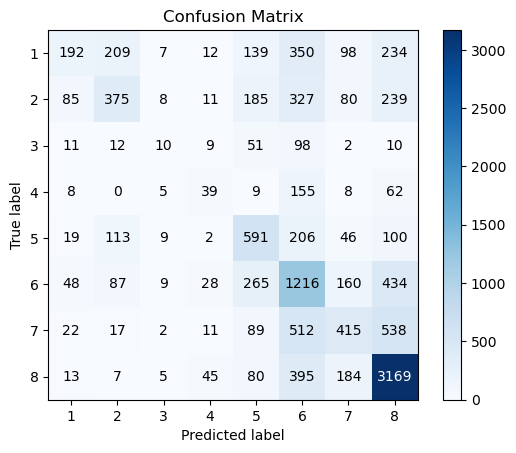

In [35]:
plot_confusion_matrix(y_test, Test_Preds)

### ROC Curve
The plot below displays the ROC curves for our model. This curve is a graph of the true positive rate versus the false positive rate for each class.


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

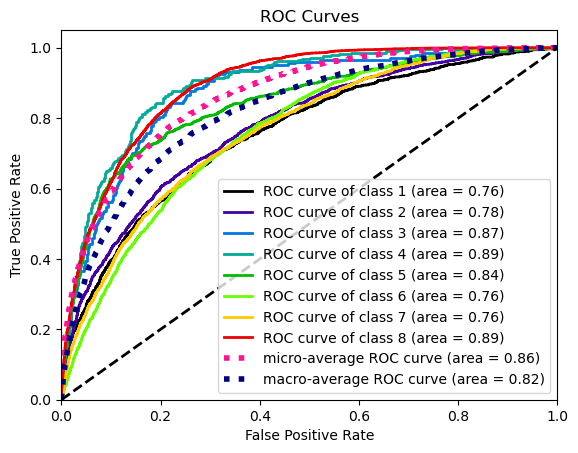

In [36]:
# Display ROC Curves
plot_roc(y_test, Test_PredProbs)

It's evident from the wide range of AUC (Area under the ROC Curve) values against each class that the model exhibits varying degrees of sensitivity and specificity across the dataset. This variability can be attributed to the data imbalance present, as highlighted by the histogram of labels displayed earlier. The differences in accuracy for each class, as depicted by the confusion matrix, further underscore the impact of this data imbalance.

While you may initially perceive the model performance as subpar, it's crucial to contextualize it against the baseline established by the best machine learning and statistical learning models submitted to the original Kaggle Competition for this dataset. [1](#R-1) [10](#R-10) When considering this context, our model's performance is satisfactory when allowing it to run for at least 200 epochs during fitting.

Moving forward, there are numerous additional features within Keras Tuner that warrant exploration and integration into your future deep learning projects. Nevertheless, you've now laid a solid foundation, encompassing the requisite structure, methodologies, and implementations for tackling risk rating-related actuarial or financial classification tasks! 

<a name='6'></a>  
## 6 - Bibliography

<a name='R-1'></a>  
1. Kaggle. (n.d.). Prudential Life Insurance Assessment: Evaluation. Retrieved from https://www.kaggle.com/competitions/prudential-life-insurance-assessment/overview/evaluation.
<a name='R-2'></a>  
2. Keras Tuner documentation for tuners. (n.d.). Retrieved from https://keras.io/api/keras_tuner/tuners/.
<a name='R-3'></a>  
3. Keras API documentation for metrics. (n.d.). Retrieved from https://keras.io/api/metrics/.
<a name='R-4'></a>  
4. Keras API documentation for losses. (n.d.). Retrieved from https://keras.io/api/losses/.
<a name='R-5'></a>  
5. Keras Tuner documentation for objective. (n.d.). Retrieved from https://keras.io/api/keras_tuner/tuners/objective/.
<a name='R-6'></a>  
6. Keras: Creating custom metrics. (n.d.). Retrieved from https://keras.io/api/metrics/#creating-custom-metrics.
<a name='R-7'></a>  
7. Keras. (2021, October 27). Tailoring the search space. Retrieved from https://keras.io/guides/keras_tuner/tailor_the_search_space/.
<a name='R-8'></a>  
8. Keras API documentation for Activations. Retrieved from https://keras.io/api/layers/activations/.
<a name='R-9'></a>  
9. Keras API documentation for Hyperparameters. Retrieved from https://keras.io/api/keras_tuner/hyperparameters/.
<a name='R-10'></a>  
10. Kaggle. (n.d.). Machine Learning for Risk Classification. Retrieved from https://www.kaggle.com/code/karansarpal/machine-learning-for-risk-classification-ks.
